# Interpretation of the latent emotional space
Here we identify the patterns learned by the emotional encoder trained.
1. Visualization of the latent space of embeddings (2D & 3D).
2. Clustering of the latent space.
3. Attribution to emotional reference patterns.

## Dependencies

In [1]:
# The following code was run on Python 3.9.7

In [2]:
# Installation of libraries (in the specific versions used).
%pip install pandas==1.4.1
%pip install numpy==1.22.2
%pip install scikit-learn==1.1.3
# scikit-learn-extra==0.2.0
# sklearn==0.0
%pip insatll matplotlib==3.1.1

You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "insatll" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Enable automatic reloading of external modules before executing code here.
%load_ext autoreload
%autoreload 2

In [4]:
# Import packages.
import os
import sys
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [5]:
# Import modules.
module_path = os.path.abspath(os.path.join('modules'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time_series_tools as ts_tools
from conv_autoencoder import ConvolutionalAutoencoder
import clustering as cl
import love_patterns as love

# Path where all the notebook's outputs will go.
output_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'new_runs') + os.sep

## Auxiliary code

In [6]:
def load_and_fit_autoencoder(
    window_steps, model_to_load, encoder_model_to_load, decoder_model_to_load, train_set_files_list_f, ae_columns
):
    path_to_trajectories = os.path.dirname(train_set_files_list_f) + os.sep
    # Load both encoder and full model.
    ae_model = ConvolutionalAutoencoder(
        window_steps,
        model_to_load=model_to_load,
        encoder_model_to_load=encoder_model_to_load,
        decoder_model_to_load=decoder_model_to_load,
    )
    # Fit model to get normalization stats from **training** set).
    with open(train_set_files_list_f) as f:
        train_set_list = f.readlines()
        train_set_list = [f'{path_to_trajectories}{line.rstrip()}' for line in train_set_list]
    _ = ae_model.fit(train_set_list, ae_columns)  # NO training here.

    return ae_model


def encode_all_the_trajectories(traj_list, ae_model):
    # Encode each of the trajectories.
    # Concatenate all encoded trajectories skipping starting NaN steps. 
    encoded_trajectories = []
    for t in traj_list:
        encoded_t = ae_model.encode_full_trajectory(t)
        encoded_trajectories.append(encoded_t)
    all_encodings = pd.concat(
        [t.df[ae_model.window_steps -1:] for t in encoded_trajectories]).drop('Step', axis=1
    )
    print(f"{len(traj_list)} Trajectory instances -> {len(all_encodings)} encodings.")

    return encoded_trajectories, all_encodings


def run_tsne_2d(
    encodings, seed=None,
    n_components=2, perplexity=30, early_exaggeration=12, learning_rate=200,
    n_iter=1000, init='pca', n_jobs=3, verbose=1
):
    """
    Train a 2D T-SNE model on the list of encodings passed, displaying the new resulting
    2D encodings.
    
    Returns:    (list) The new 2D encodings.
                (list) The new 2D encodings, min-max normalized.
                (TSNE) The trained model.
    """
    # Dim. reduction:
    if seed:
        np.random.seed(seed)
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        early_exaggeration=early_exaggeration,
        learning_rate=learning_rate,
        n_iter=n_iter,
        init=init,
        n_jobs=n_jobs,
        verbose=verbose)  # Tip: perplexity ≈ sqrt(N), with N ≈ 20K
    encodings_tsne = tsne.fit_transform(encodings)
    # Draw results:
    encodings_tsne_norm = (encodings_tsne - encodings_tsne.min()) / (encodings_tsne.max() - encodings_tsne.min())
    plt.scatter(encodings_tsne_norm[:, 0], encodings_tsne_norm[:, 1], alpha=0.1, s=5)
    plt.axis("off")
    plt.show()

    return encodings_tsne, encodings_tsne_norm, tsne


def save_complete_encodings_set(model_name, encodings_tsne, output_path=None):
    dim_encodings = encodings_tsne[0].shape[0]  # Take length of first encoding.
    df = pd.DataFrame(
        data=encodings_tsne,
        columns=[str(i) for i in range(dim_encodings)]
    )
    path = f"{model_name}" if output_path is None else os.path.join(output_path)
    if not os.path.exists(path):
        os.makedirs(path)
    df.to_csv(
        f"{path}/all_trajectories_enc_2D.txt",
        sep='\t', header=df.columns,
        # index=True, index_label='Step'
    )

def save_all_2d_trajectory_encodings(model_name, traj_list, encodings_tsne, window_steps):
    dim_encodings = encodings_tsne[0].shape[0]  # Take length of first encoding.
    from_enc = 0  # Index of first encoding in 'encodings_tsne'.
    for t in traj_list:
        # Data: empty first steps.
        blank_values = np.empty((window_steps - 1, dim_encodings))
        blank_values[:] = np.nan

        # Data: pack the full trajectory.
        to_enc = from_enc + t.len - window_steps + 1
        data = np.append(blank_values, encodings_tsne[from_enc:to_enc], axis=0)
        df = pd.DataFrame(
            data=data,
            columns=[str(i) for i in range(dim_encodings)]
        )
        
        # Save to file.
        path = f"{model_name}/{t.path_to_log.split('/')[-2]}/"
        if not os.path.exists(path):
            os.makedirs(path)
        file = t.log_file.split('.')[0] + '_enc_2D.txt'
        print(f"Saving to {path}{file} encodings_tsne[{from_enc}:{to_enc}]")
        df.to_csv(
            f"{path}{file}",
            sep='\t', header=df.columns,
            index=True, index_label='Step'
        )

        from_enc = to_enc

## Interpretation of the latent emotinal space

### 1. Visualization of the learned latent space

#### Load the recorded trajectories

In [7]:
# Read all the recorded trajectories (training + test set = 60 traj.):
path_to_series = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'trajectories', 'test_series_s*') + os.sep
experiment_id = 'Exp-05.02'
columns=['Step', 'Reward', 'Value']
traj_list = ts_tools.read_all_trajectories_in_path(
    path_to_series,
    experiment_id=experiment_id,
    columns=columns,
    verbose=True
)

60 trajectories read.
Example: 
Exp-05.02 (episode_4.txt)
      Step    Reward      Value
0        0  0.000000  68.453072
1        1  0.024697  69.105492
2        2  3.130233  66.474655
3        3 -0.359940  67.537750
4        4  0.162538  68.540581
...    ...       ...        ...
996    996  1.919042  73.464653
997    997  1.628644  74.439430
998    998 -1.728141  75.311012
999    999 -1.635396  74.080360
1000  1000  1.657513   0.000000

[1001 rows x 3 columns]


#### Load the Autoencoder model

In [8]:
# Location of the recorded trajectories:
path_to_model = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'autoencoder') + os.sep

model_to_load = f'{path_to_model}conv_1d_model_06'
encoder_model_to_load = f'{path_to_model}conv_1d_model_06_encoder'
decoder_model_to_load = f'{path_to_model}conv_1d_model_06_decoder'
window_steps = 20
ae_columns = ['Reward', 'Value']
model_name = model_to_load.split(os.sep)[-1]

# Normalization: trajectories used:
train_set_files_list_f = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'trajectories', 'train_set_files.txt')

In [9]:
# Load the Autoencoder model:
# (The model is NOT trained here; normalization stats of the MTS are taken from training set.)
ae_model = load_and_fit_autoencoder(
    window_steps,
    model_to_load,
    encoder_model_to_load,
    decoder_model_to_load,
    train_set_files_list_f,
    ae_columns
)

ae_model.encode_at_step(traj_list[0], at_step=30)  # Quick test.

2024-03-24 11:42:51.780850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


array([3.6457808, 1.9298749, 2.9409716, 2.7137547, 3.613246 ],
      dtype=float32)

#### Generate the encoded MTS for all the trajectories

In [10]:
encoded_trajectories, all_encodings = encode_all_the_trajectories(traj_list, ae_model)

60 Trajectory instances -> 20220 encodings.


In [11]:
all_encodings.describe()

,0,1,2,3,4
count,20220.000000,20220.000000,20220.000000,20220.000000,20220.000000
mean,4.435353,2.675322,3.161715,2.695211,3.629301
std,2.508391,1.366789,1.664937,1.361223,1.961723
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.418951,1.686846,1.977131,1.687876,2.154464
50%,3.987078,2.451532,2.895724,2.528594,3.265063
75%,6.318376,3.543995,4.198052,3.575106,4.975724
max,14.192752,10.103378,13.125732,10.883862,14.087424


#### Dimensionality reduction

2D t-SNE

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 20220 samples in 0.010s...
[t-SNE] Computed neighbors for 20220 samples in 3.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20220
[t-SNE] Computed conditional probabilities for sample 2000 / 20220
[t-SNE] Computed conditional probabilities for sample 3000 / 20220
[t-SNE] Computed conditional probabilities for sample 4000 / 20220
[t-SNE] Computed conditional probabilities for sample 5000 / 20220
[t-SNE] Computed conditional probabilities for sample 6000 / 20220
[t-SNE] Computed conditional probabilities for sample 7000 / 20220
[t-SNE] Computed conditional probabilities for sample 8000 / 20220
[t-SNE] Computed conditional probabilities for sample 9000 / 20220
[t-SNE] Computed conditional probabilities for sample 10000 / 20220
[t-SNE] Computed conditional probabilities for sample 11000 / 20220
[t-SNE] Computed conditional probabilities for sample 12000 / 20220
[t-SNE] Computed conditional probabilities for sa

/Users/Alberto/Code/love-emotional-framework/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.426071
[t-SNE] KL divergence after 2000 iterations: 1.292067


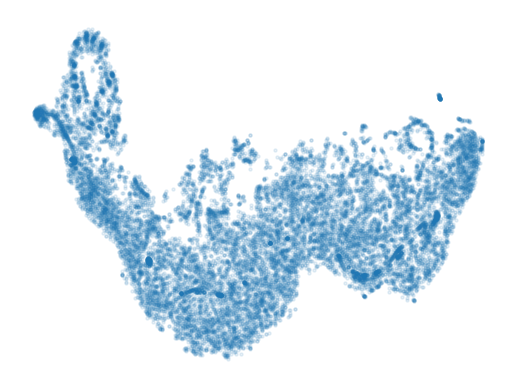

In [12]:
encodings_tsne, encodings_tsne_norm, tsne = run_tsne_2d(
    all_encodings, seed=90, n_components=2,
    perplexity=200, init='pca', n_iter=2000,
    n_jobs=4, verbose=1
)

In [13]:
# Save the 2D encodings set.
save_complete_encodings_set(model_name, encodings_tsne, output_path=output_path)

3D t-SNE

In [14]:
np.random.seed(42)
tsne = TSNE(n_components=3, perplexity=200, init='pca', n_iter=2000, n_jobs=4, verbose=1)
encodings_3d = tsne.fit_transform(all_encodings)

/Users/Alberto/Code/love-emotional-framework/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 20220 samples in 0.009s...
[t-SNE] Computed neighbors for 20220 samples in 2.567s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20220
[t-SNE] Computed conditional probabilities for sample 2000 / 20220
[t-SNE] Computed conditional probabilities for sample 3000 / 20220
[t-SNE] Computed conditional probabilities for sample 4000 / 20220
[t-SNE] Computed conditional probabilities for sample 5000 / 20220
[t-SNE] Computed conditional probabilities for sample 6000 / 20220
[t-SNE] Computed conditional probabilities for sample 7000 / 20220
[t-SNE] Computed conditional probabilities for sample 8000 / 20220
[t-SNE] Computed conditional probabilities for sample 9000 / 20220
[t-SNE] Computed conditional probabilities for sample 10000 / 20220
[t-SNE] Computed conditional probabilities for sample 11000 / 20220
[t-SNE] Computed conditional probabilities for sample 12000 / 20220
[t-SNE] Computed conditional probabilities for sa

/Users/Alberto/Code/love-emotional-framework/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.909332
[t-SNE] KL divergence after 2000 iterations: 1.100060


In [15]:
# Normalization.
encodings_3d_norm = (encodings_3d - encodings_3d.min()) / (encodings_3d.max() - encodings_3d.min())
encodings_3d_norm.shape

(20220, 3)

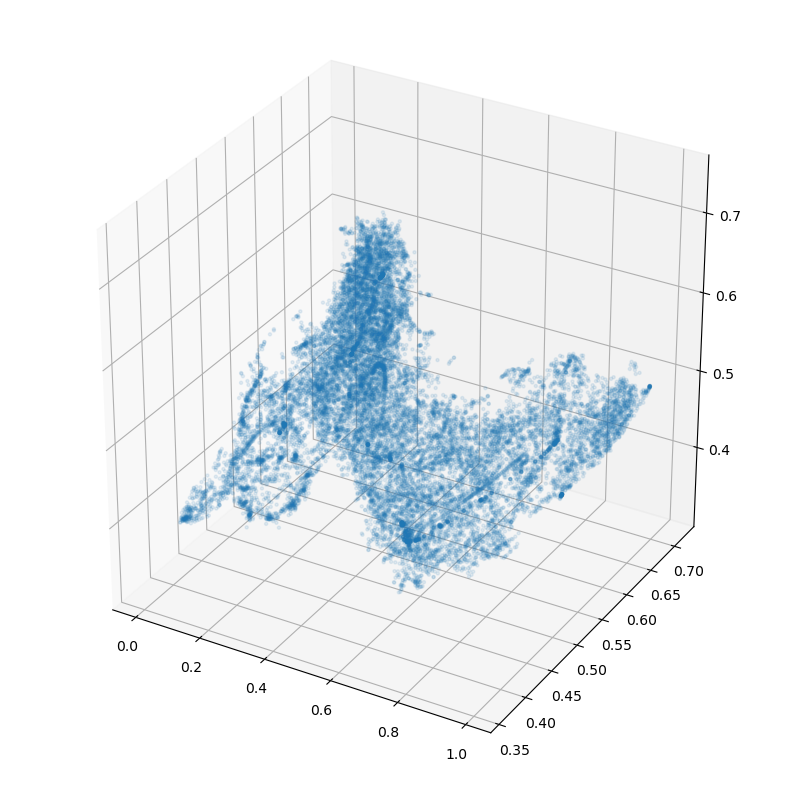

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(encodings_3d_norm[:, 0], encodings_3d_norm[:, 1], encodings_3d_norm[:, 2], s=5, alpha=0.1)
plt.show()

Plot in 3D (animated)

In [17]:
def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save(f"{output_path}3d_rotation.gif", writer=animation.PillowWriter(fps=20))

Result

<img src="../data/new_runs/3d_rotation.gif" alt="drawing" width="600"/>

### 2. Clustering of the learned latent space

#### Generate the encoded MTS for all the trajectories

In [18]:
# Un-normalized endodings:
encoded_trajectories, all_encodings = ae_model.encode_list_of_trajectories(traj_list)

60 Trajectory instances -> 20220 encodings.


In [19]:
all_encodings

,0,1,2,3,4
0,4.386054,2.877415,3.609508,3.509694,3.553517
1,4.296275,2.692203,3.605160,3.450062,3.509353
2,4.170683,2.730966,3.646394,3.352107,3.552239
3,4.033046,2.642388,3.579746,3.392107,3.649188
4,3.929564,2.522040,3.544691,3.355485,3.657174
...,...,...,...,...,...
20215,6.688306,3.777233,4.421291,3.659997,5.254293
20216,6.689663,3.780382,4.423835,3.655373,5.250803
20217,6.689044,3.784252,4.424615,3.652684,5.250301
20218,6.688540,3.784033,4.424464,3.653680,5.251190


In [20]:
# Normalized encodings.
norm_encodings = (all_encodings - all_encodings.mean())/all_encodings.std()

#### Clustering and classification of all embeddings

In [21]:
# Gaussian mixture model
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

In [22]:
# Train the model (try several hyperparameters):
n_components, covariance_type, seed = 8, 'full', 7014
gm_model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=seed, verbose=2).fit(all_encodings)

Initialization 0
  Iteration 10	 time lapse 0.33748s	 ll change 0.00609
  Iteration 20	 time lapse 0.20974s	 ll change 0.03073
  Iteration 30	 time lapse 0.21147s	 ll change 0.00161
Initialization converged: True	 time lapse 0.82294s	 ll -5.27909


In [23]:
# These are the learned centroids.
gm_model.means_

array([[1.29591249, 1.24650838, 1.3685668 , 1.17463421, 1.3353045 ],
       [6.79870117, 3.81349766, 4.50099998, 3.77166472, 5.35746099],
       [3.1969202 , 2.06569991, 2.41133579, 2.14451399, 2.69820316],
       [6.92860891, 4.11258154, 5.71956227, 4.59058983, 6.09245219],
       [7.6828346 , 4.21698524, 4.96324907, 4.12532399, 6.00753708],
       [1.88986478, 1.40784099, 1.60872662, 1.43589356, 1.69779835],
       [5.5954452 , 3.17102147, 3.72147846, 3.13065132, 4.39756925],
       [3.33228604, 2.29017284, 2.67506284, 2.41146088, 2.90010794]])

0:	1765
1:	898
2:	6023
3:	733
4:	3341
5:	2536
6:	3950
7:	974


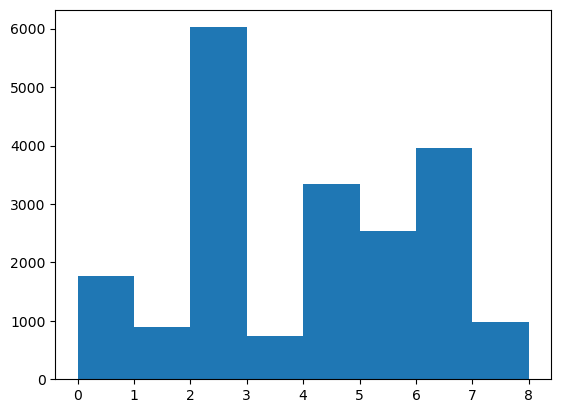

In [24]:
# Classify all the points in the emotional latent space.
gm_labels = gm_model.predict(all_encodings)

hist_data = plt.hist(gm_labels, np.arange(n_components + 1))
for i in range(n_components):
    print(f"{i}:\t{int(hist_data[0][i])}")

In [25]:
# Estimate cluster probabilities for all the points in the emotional latent space.
gm_labels_prob = gm_model.predict_proba(all_encodings)  # (20,220 x 8)

gm_labels_prob[0]  # Cluster probabilites of the first point.

array([4.90307178e-26, 6.49233335e-10, 7.26462674e-01, 8.81445620e-05,
       1.56996105e-02, 2.27164698e-05, 2.53093680e-01, 4.63317429e-03])

In [26]:
# Categorize all steps of trajectories.
ref_encodings, encoded_trajectories = ae_model.encode_and_reference_list_of_trajectories(traj_list)
ref_encodings['Cluster'] = gm_labels
ref_encodings.head()

60 Trajectory instances -> 20220 encodings.


,0,1,2,3,4,Step,Seed,Episode,Cluster
0,4.386054,2.877415,3.609508,3.509694,3.553517,19,30,4,2
1,4.296275,2.692203,3.605160,3.450062,3.509353,20,30,4,2
2,4.170683,2.730966,3.646394,3.352107,3.552239,21,30,4,2
3,4.033046,2.642388,3.579746,3.392107,3.649188,22,30,4,2
4,3.929564,2.522040,3.544691,3.355485,3.657174,23,30,4,2


In [27]:
df_probs = pd.DataFrame(gm_labels_prob)
df_probs[['Step', 'Seed', 'Episode', 'Cluster']] = ref_encodings[['Step', 'Seed', 'Episode', 'Cluster']]
df_probs['Probability'] = df_probs[np.arange(n_components)].max(axis=1)  # Capture max. probability from clusters prob.
df_probs.head()

,0,1,2,3,4,5,6,7,Step,Seed,Episode,Cluster,Probability
0,4.903072e-26,6.492333e-10,0.726463,0.000088,0.015700,0.000023,0.253094,0.004633,19,30,4,2,0.726463
1,1.047058e-24,4.634488e-14,0.763535,0.000071,0.013285,0.000061,0.218117,0.004931,20,30,4,2,0.763535
2,6.010529e-24,8.831836e-20,0.810584,0.000052,0.009769,0.008752,0.166582,0.004261,21,30,4,2,0.810584
3,4.657595e-23,1.312340e-26,0.846970,0.000051,0.009461,0.001696,0.136951,0.004870,22,30,4,2,0.846970
4,6.333037e-22,3.763568e-45,0.857352,0.000052,0.009572,0.000394,0.126602,0.006028,23,30,4,2,0.857352


#### Visualization of the clusters within latent space

Display average sequence of each cluster

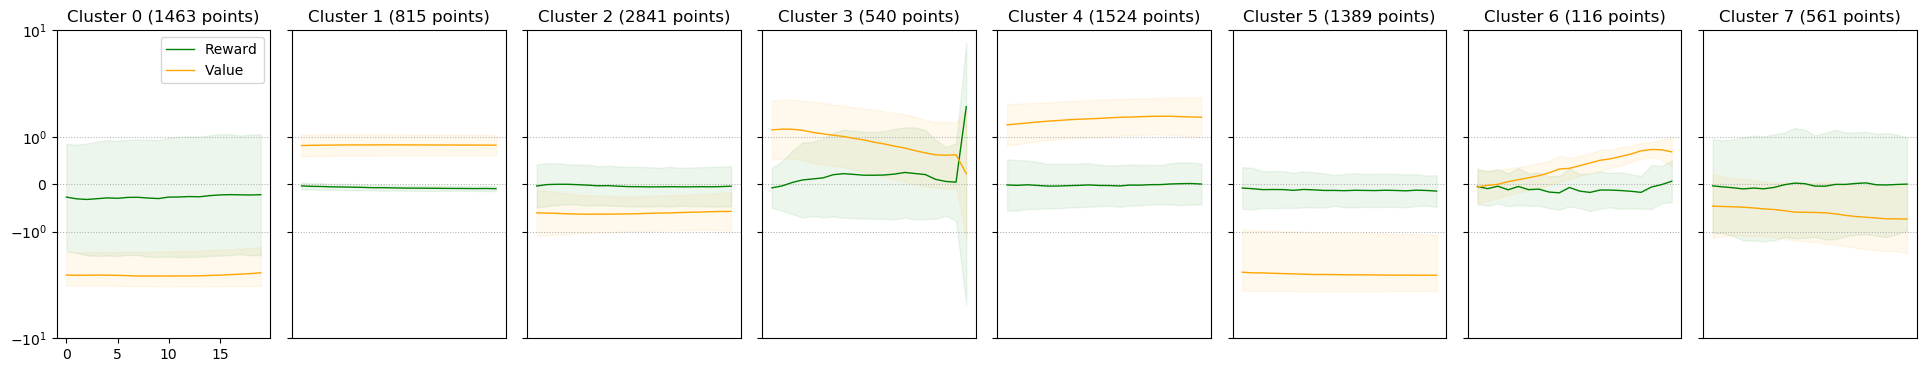

In [28]:
cl.draw_average_sequence_in_clusters_in_a_row(
    gm_model.means_, ae_model, ae_columns, df_probs, traj_list, window_steps, min_probability=0.9, log_scale=True
)

Display the original trajectories of several cluster members

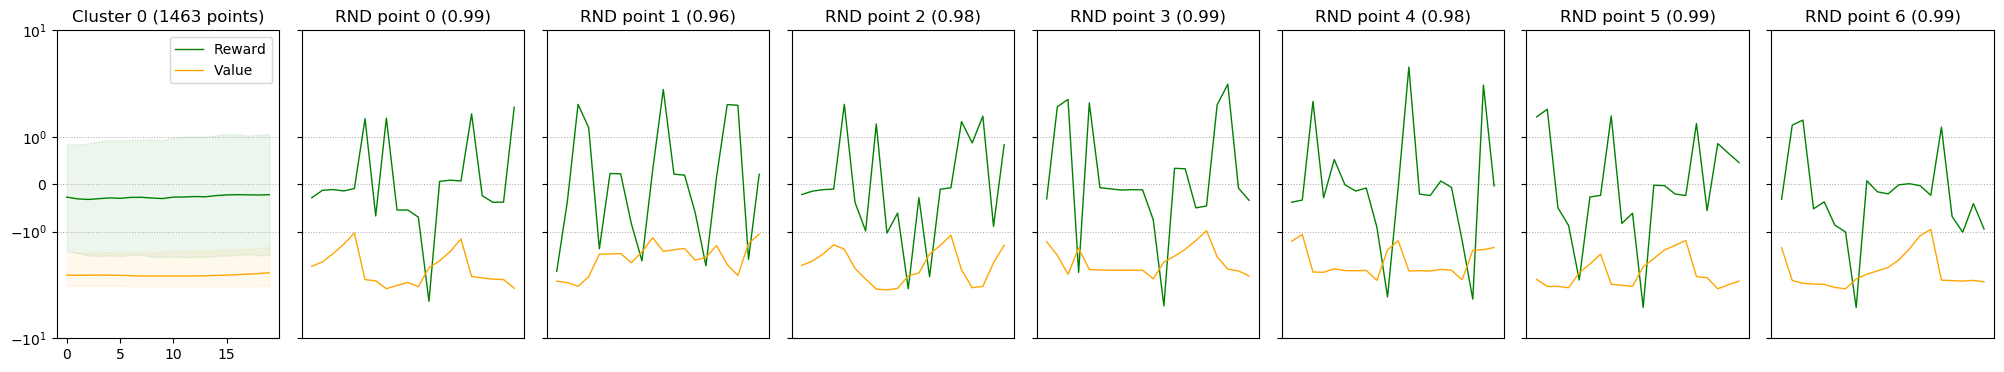

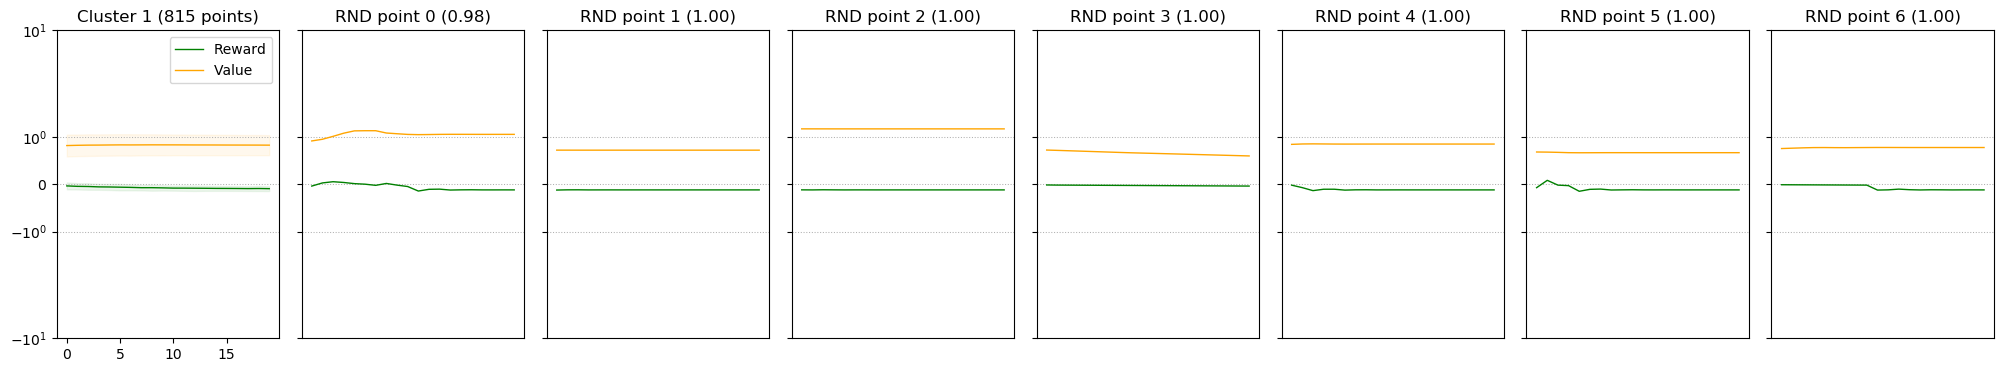

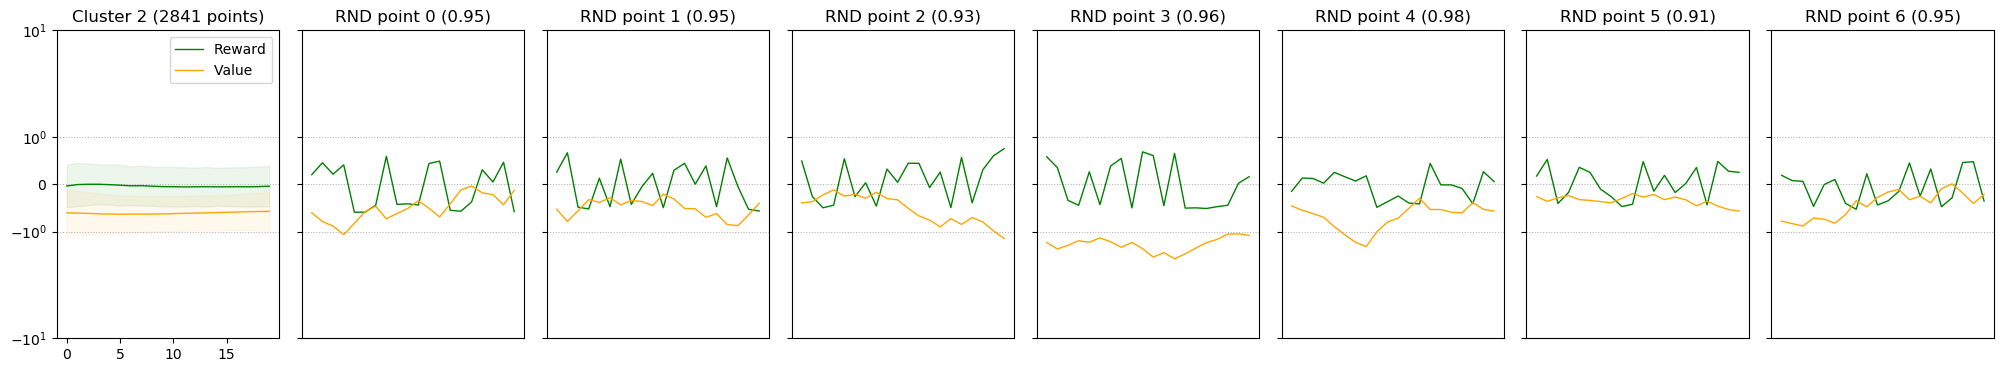

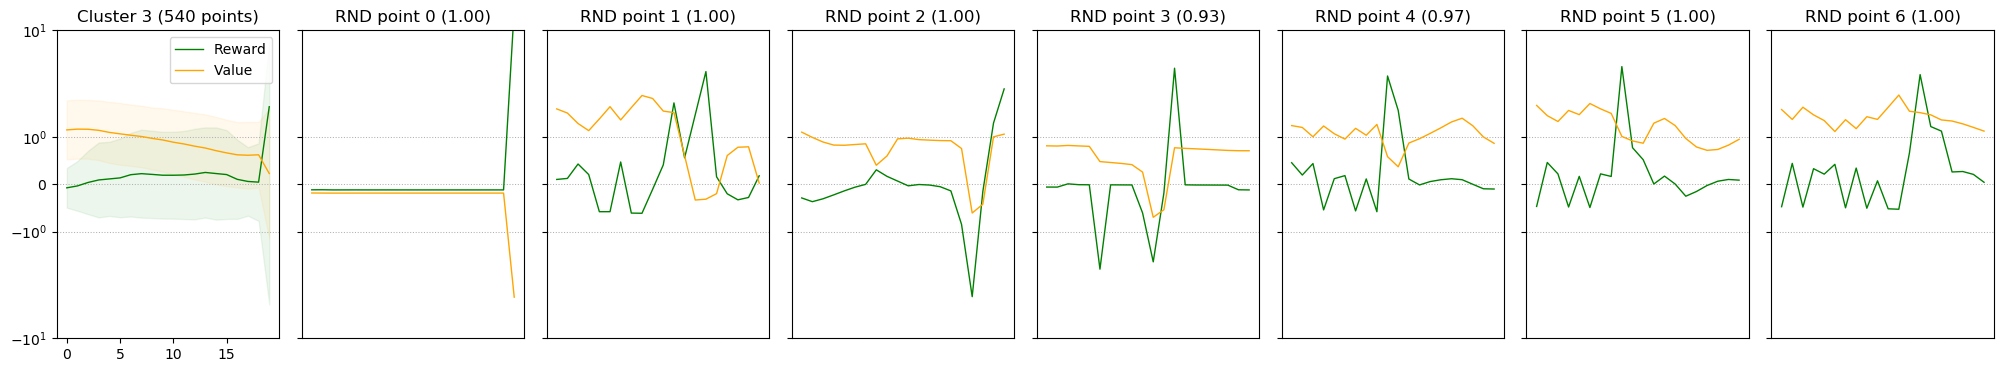

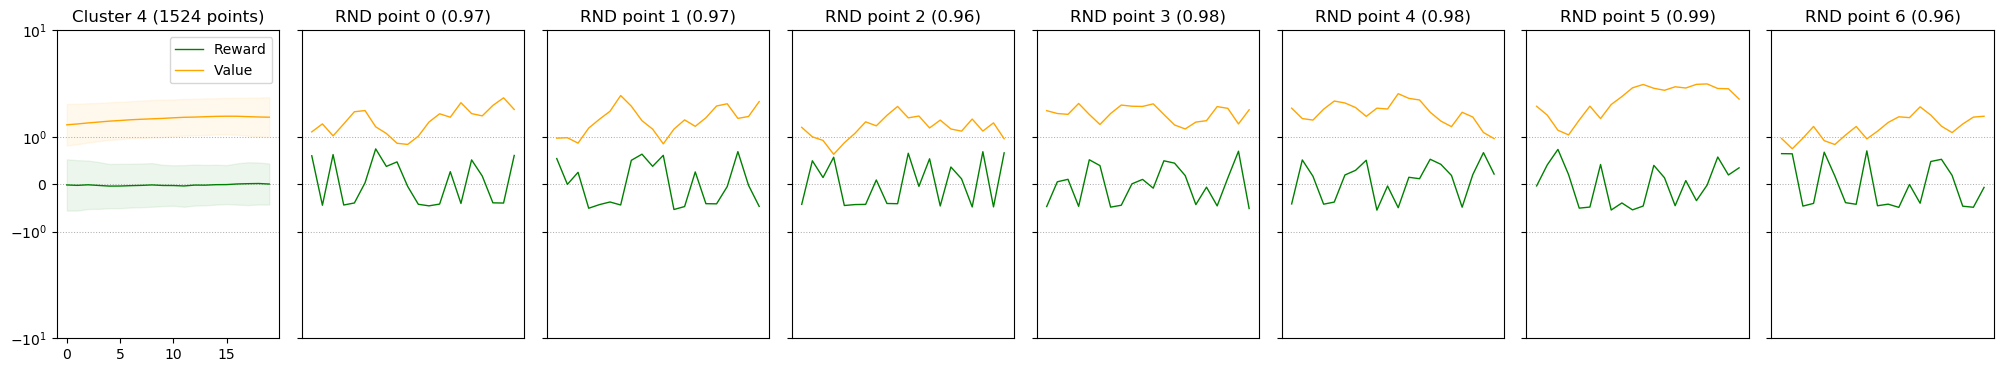

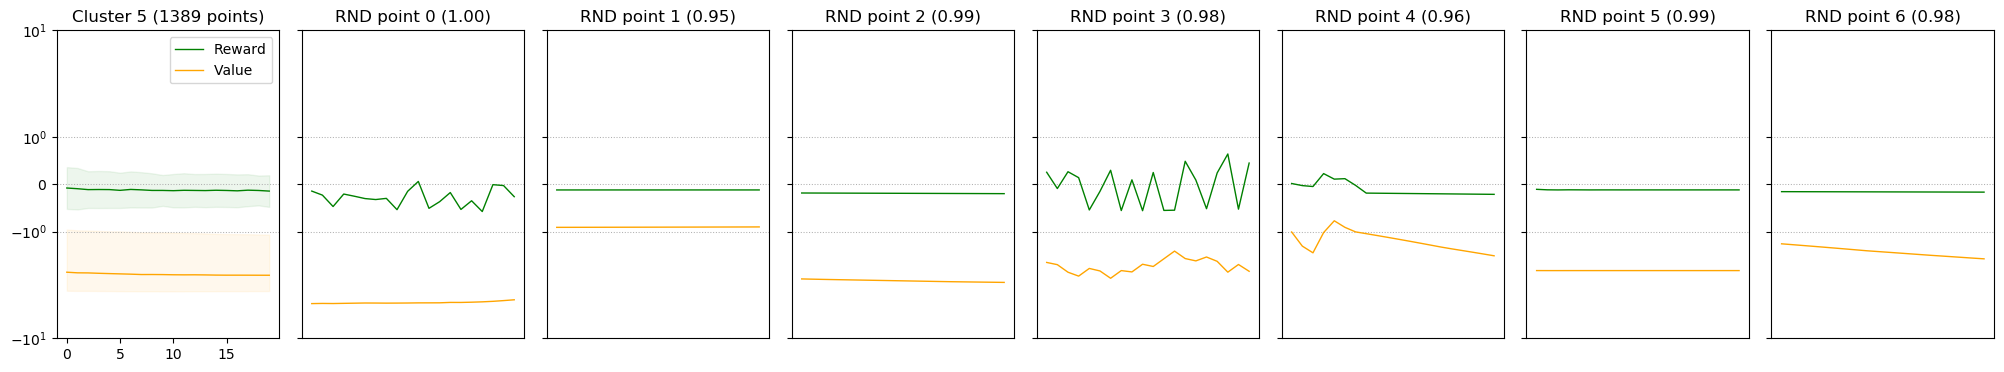

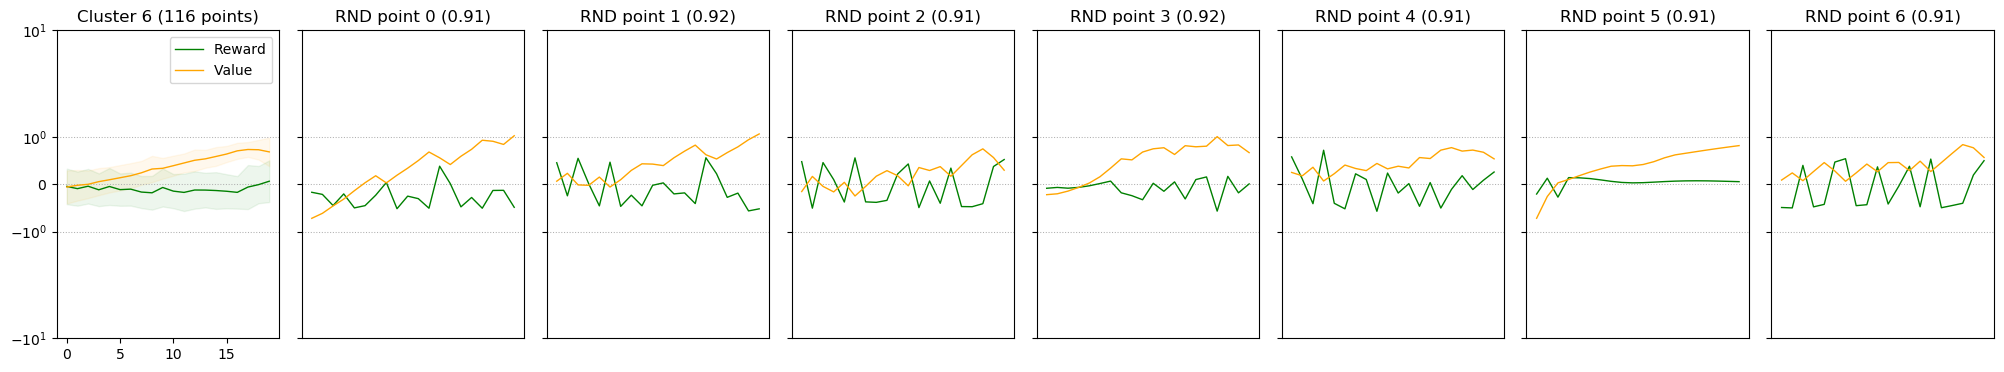

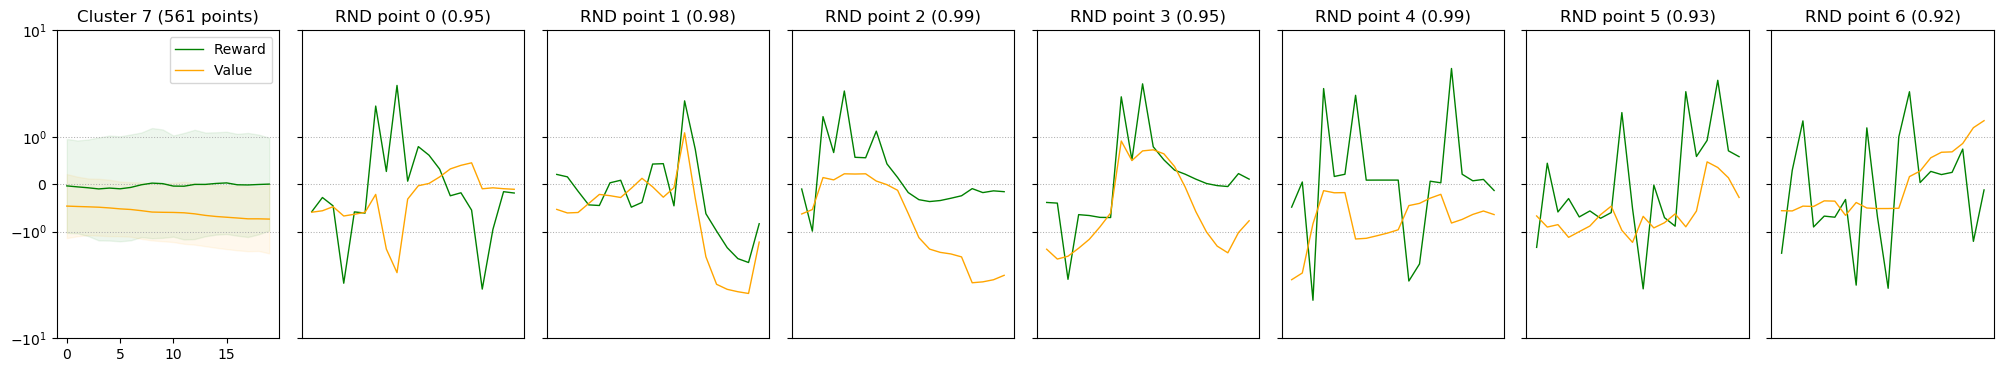

In [29]:
# Selection parameters:
min_probability = 0.9
seed = 4
num_members = 7
# Draw average sequece of each cluster and 'num_members' cluster members:
cl.draw_average_sequences_and_cluster_members(
    gm_model.means_, ae_model, ae_columns, df_probs, traj_list, window_steps,
    min_probability=min_probability, seed=seed, num_members=num_members, log_scale=True
)

Draw clusters in 2D

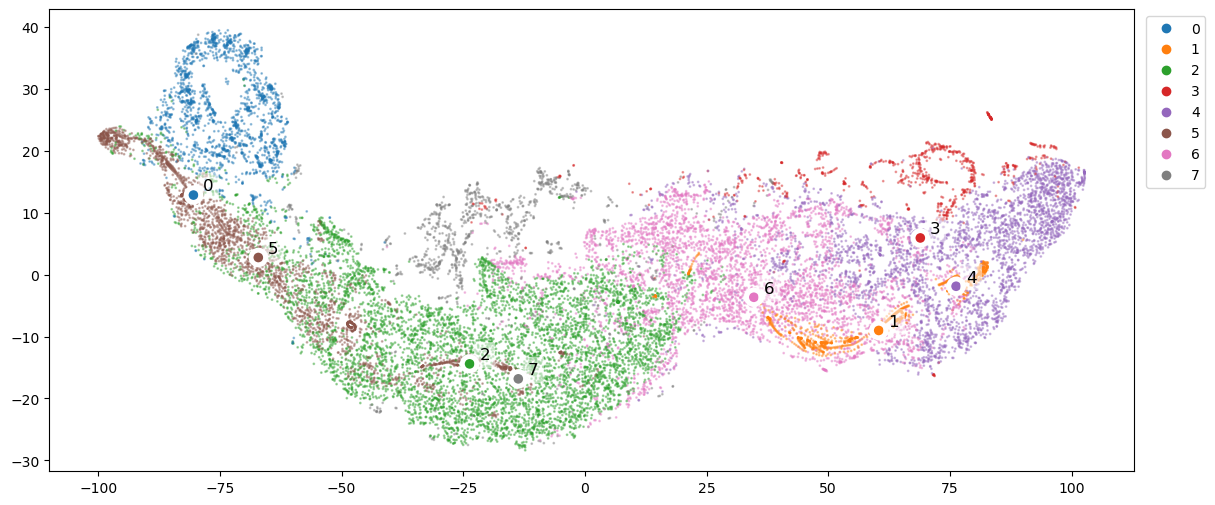

In [30]:
conv_model_path = os.path.join('..', 'data', 'original', 'interpretation')
cl.draw_gm_model_2d_clusters(conv_model_path, gm_model, gm_labels, all_encodings, n_components, draw_centroids=True)

Draw clusters in 3D

In [31]:
encodings_3d_norm = (encodings_3d - encodings_3d.min()) / (encodings_3d.max() - encodings_3d.min())
encodings_3d_norm.shape

(20220, 3)

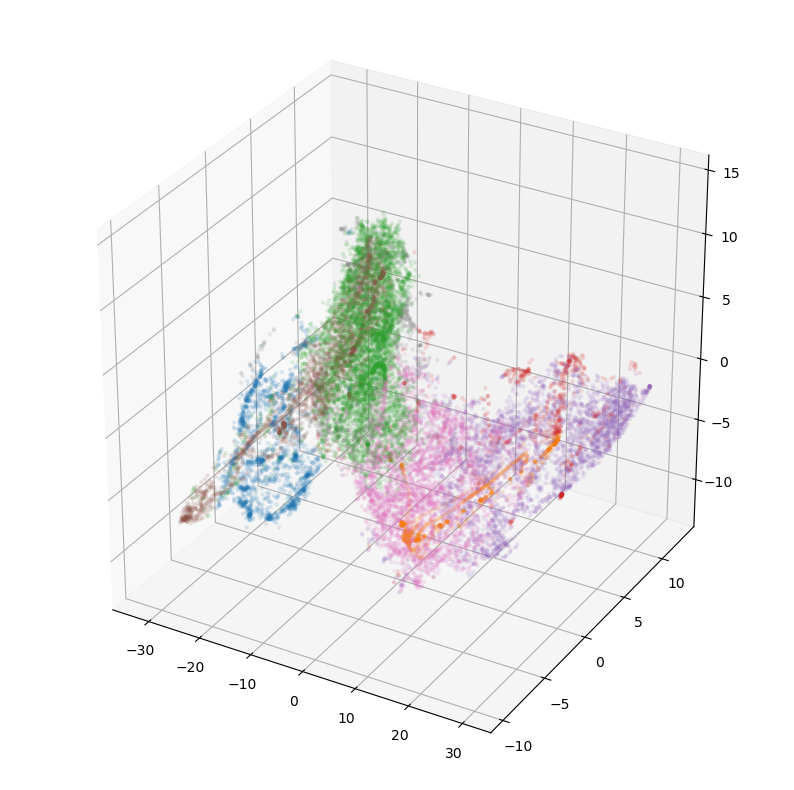

In [32]:
# These are matplotlib's Qualitative color palettes:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
if n_components <= 10:
    palette = 'tab10'
else:
    palette = 'tab20'
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap(palette).colors[:n_components])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(encodings_3d[:, 0], encodings_3d[:, 1], encodings_3d[:, 2], s=5, alpha=0.1, c=gm_labels, cmap=cmap)
plt.show()

Animation of clusters in 3D

In [33]:
angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save(f"{output_path}3d_clusters_rotation.gif", writer=animation.PillowWriter(fps=20))

Result

<img src="../data/new_runs/3d_clusters_rotation.gif" alt="drawing" width="600"/>

### 3. Attribution of learned patterns to LOVE 2:5x6 reference profiles

##### Interpretation of the learned patterns

In [34]:
def create_list_of_univariate_ts(norm_traj_list, column):
    return [t.df[column] for t in norm_traj_list]

1. Analyze the statistics of the original MTS trajectories of the agent for each variable.

In [35]:
# Normalize all the original MTS trajectories, and extract their univariate series.
norm_traj_list, _, _ = ts_tools.z_score_normalize_trajectory_list(
    traj_list, ae_model.mean_value_dict, ae_model.std_value_dict
)
list_of_univar_reward_ts = create_list_of_univariate_ts(norm_traj_list, 'Reward')
list_of_univar_value_ts = create_list_of_univariate_ts(norm_traj_list, 'Value')

# Capture the key statistics for each variable.
# 1. Descriptive stats (mean = 0, std = 1) => Differentiate normal vs high/low values.
mean_rew, std_rew = 0.0, 1.0
mean_val, std_val = 0.0, 1.0
# 2. Slope stats => Differentiate normal vs outstanding trend changes.
mean_slope_rew, mean_slope_size_rew, mean_positive_slope_rew, mean_negative_slope_rew = \
    love.get_slope_stats_of_many_normalized_ts(list_of_univar_reward_ts, window_steps, verbose=True)
mean_slope_val, mean_slope_size_val, mean_positive_slope_val, mean_negative_slope_val = \
    love.get_slope_stats_of_many_normalized_ts(list_of_univar_value_ts, window_steps, verbose=True)


Slope stats of the list of TS's:
(-)mean, mean, (+)mean = -0.01435, 0.0004716, 0.01698
(abs) mean = 0.01559

Slope stats of the list of TS's:
(-)mean, mean, (+)mean = -0.02151, 0.001478, 0.02336
(abs) mean = 0.02246



2. Obtain the average multivariate sequence representing the learned cluster centroids.

In [36]:
sequence_list = cl.get_average_sequences(
    gm_model.means_, ae_model, ae_columns, df_probs, traj_list, window_steps, min_probability=0.9
)

3. Compare each learned MTS pattern to original MTS statistics.

In [37]:
# Identify LOVE x5 patterns for variable 'Reward':
love.obtain_love_pattern_of_sequences_based_on_historic_mts(
    mean_slope_size_rew, sequence_list,
    'Reward', love_pattern=5
)

'Reward' LOVE x5 patterns:
- Cluster 0: Negative       	 mean = -0.2679 (+/- 1.2381)	 slope +0.0048 vs mean_slope_size 0.0156
- Cluster 1: Average        	 mean = -0.0726 (+/- 0.0590)	 slope -0.0028 vs mean_slope_size 0.0156
- Cluster 2: Average        	 mean = -0.0368 (+/- 0.4223)	 slope -0.0025 vs mean_slope_size 0.0156
- Cluster 3: Increased      	 mean = +0.2117 (+/- 1.0695)	 slope +0.0275 vs mean_slope_size 0.0156
- Cluster 4: Average        	 mean = -0.0155 (+/- 0.4590)	 slope +0.0018 vs mean_slope_size 0.0156
- Cluster 5: Average        	 mean = -0.1224 (+/- 0.3659)	 slope -0.0021 vs mean_slope_size 0.0156
- Cluster 6: Average        	 mean = -0.0992 (+/- 0.3772)	 slope +0.0010 vs mean_slope_size 0.0156
- Cluster 7: Average        	 mean = -0.0270 (+/- 1.0839)	 slope +0.0046 vs mean_slope_size 0.0156


In [38]:
# Identify LOVE x6 patterns for variable 'Value':
love.obtain_love_pattern_of_sequences_based_on_historic_mts(
    mean_slope_size_val, sequence_list,
    'Value', love_pattern=6
)

'Value' LOVE x6 patterns:
- Cluster 0: high Negative  	 mean = -1.9240 (+/- 0.5142)	 slope +0.0015 vs mean_slope_size 0.0225
- Cluster 1: high Positive  	 mean = +0.8304 (+/- 0.2212)	 slope +0.0002 vs mean_slope_size 0.0225
- Cluster 2: Negative       	 mean = -0.6099 (+/- 0.3978)	 slope +0.0025 vs mean_slope_size 0.0225
- Cluster 3: Decreased to avg.	 mean = +0.8762 (+/- 0.7051)	 slope -0.0399 vs mean_slope_size 0.0225
- Cluster 4: high Positive  	 mean = +1.3809 (+/- 0.4012)	 slope +0.0089 vs mean_slope_size 0.0225
- Cluster 5: high Negative  	 mean = -1.9056 (+/- 0.8849)	 slope -0.0031 vs mean_slope_size 0.0225
- Cluster 6: Increased      	 mean = +0.3636 (+/- 0.2420)	 slope +0.0457 vs mean_slope_size 0.0225
- Cluster 7: Decreased to neg.	 mean = -0.5979 (+/- 0.6382)	 slope -0.0160 vs mean_slope_size 0.0225


4. Attribution of emotion terms based on LOVE patterns

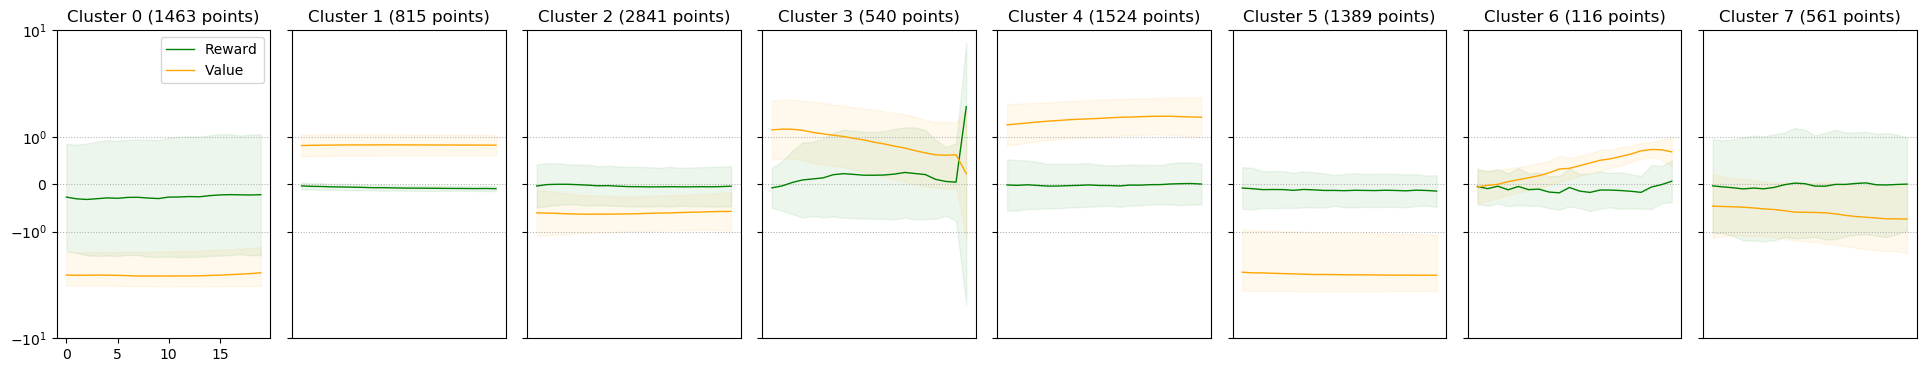

In [39]:
# Code taken from above, copied for illustrative purposes.
# cl.draw_average_sequence_in_clusters_in_a_row(
#     gm_model.means_, ae_model, ae_columns, df_probs, traj_list, window_steps, min_probability=0.9, log_scale=True
# )

LOVE 2:5x6 reference profiles

<img src="../data/original/interpretation/LOVE 2-5x6.png" alt="drawing" width="500"  style="margin-left: 20px;"/>

In [40]:
emotional_attribution = {
    0: 'Distress',
    1: 'Optimism',
    2: 'Neutral',
    3: 'Satisfaction',
    4: 'high Optimism',
    5: 'Concern',
    6: 'Excitement',
    7: 'Fear',
}

##### Visualize step-wise clusterings of one trajectory

In [41]:
# Smoothen original probabilities (5), then cluster allocation (0.9, 10). Best
df_probs_smooth_moving_avg = cl.moving_avg_cluster_allocation(df_probs, n_components, window=5, renormalize=True)
df_probs_smooth = cl.smoothen_cluster_allocation(df_probs_smooth_moving_avg, min_threshold=0.9, min_failed_surpasses=10)

In [42]:
# Choose an episode (original seed used, number of episode)
seed, episode = 30, 6

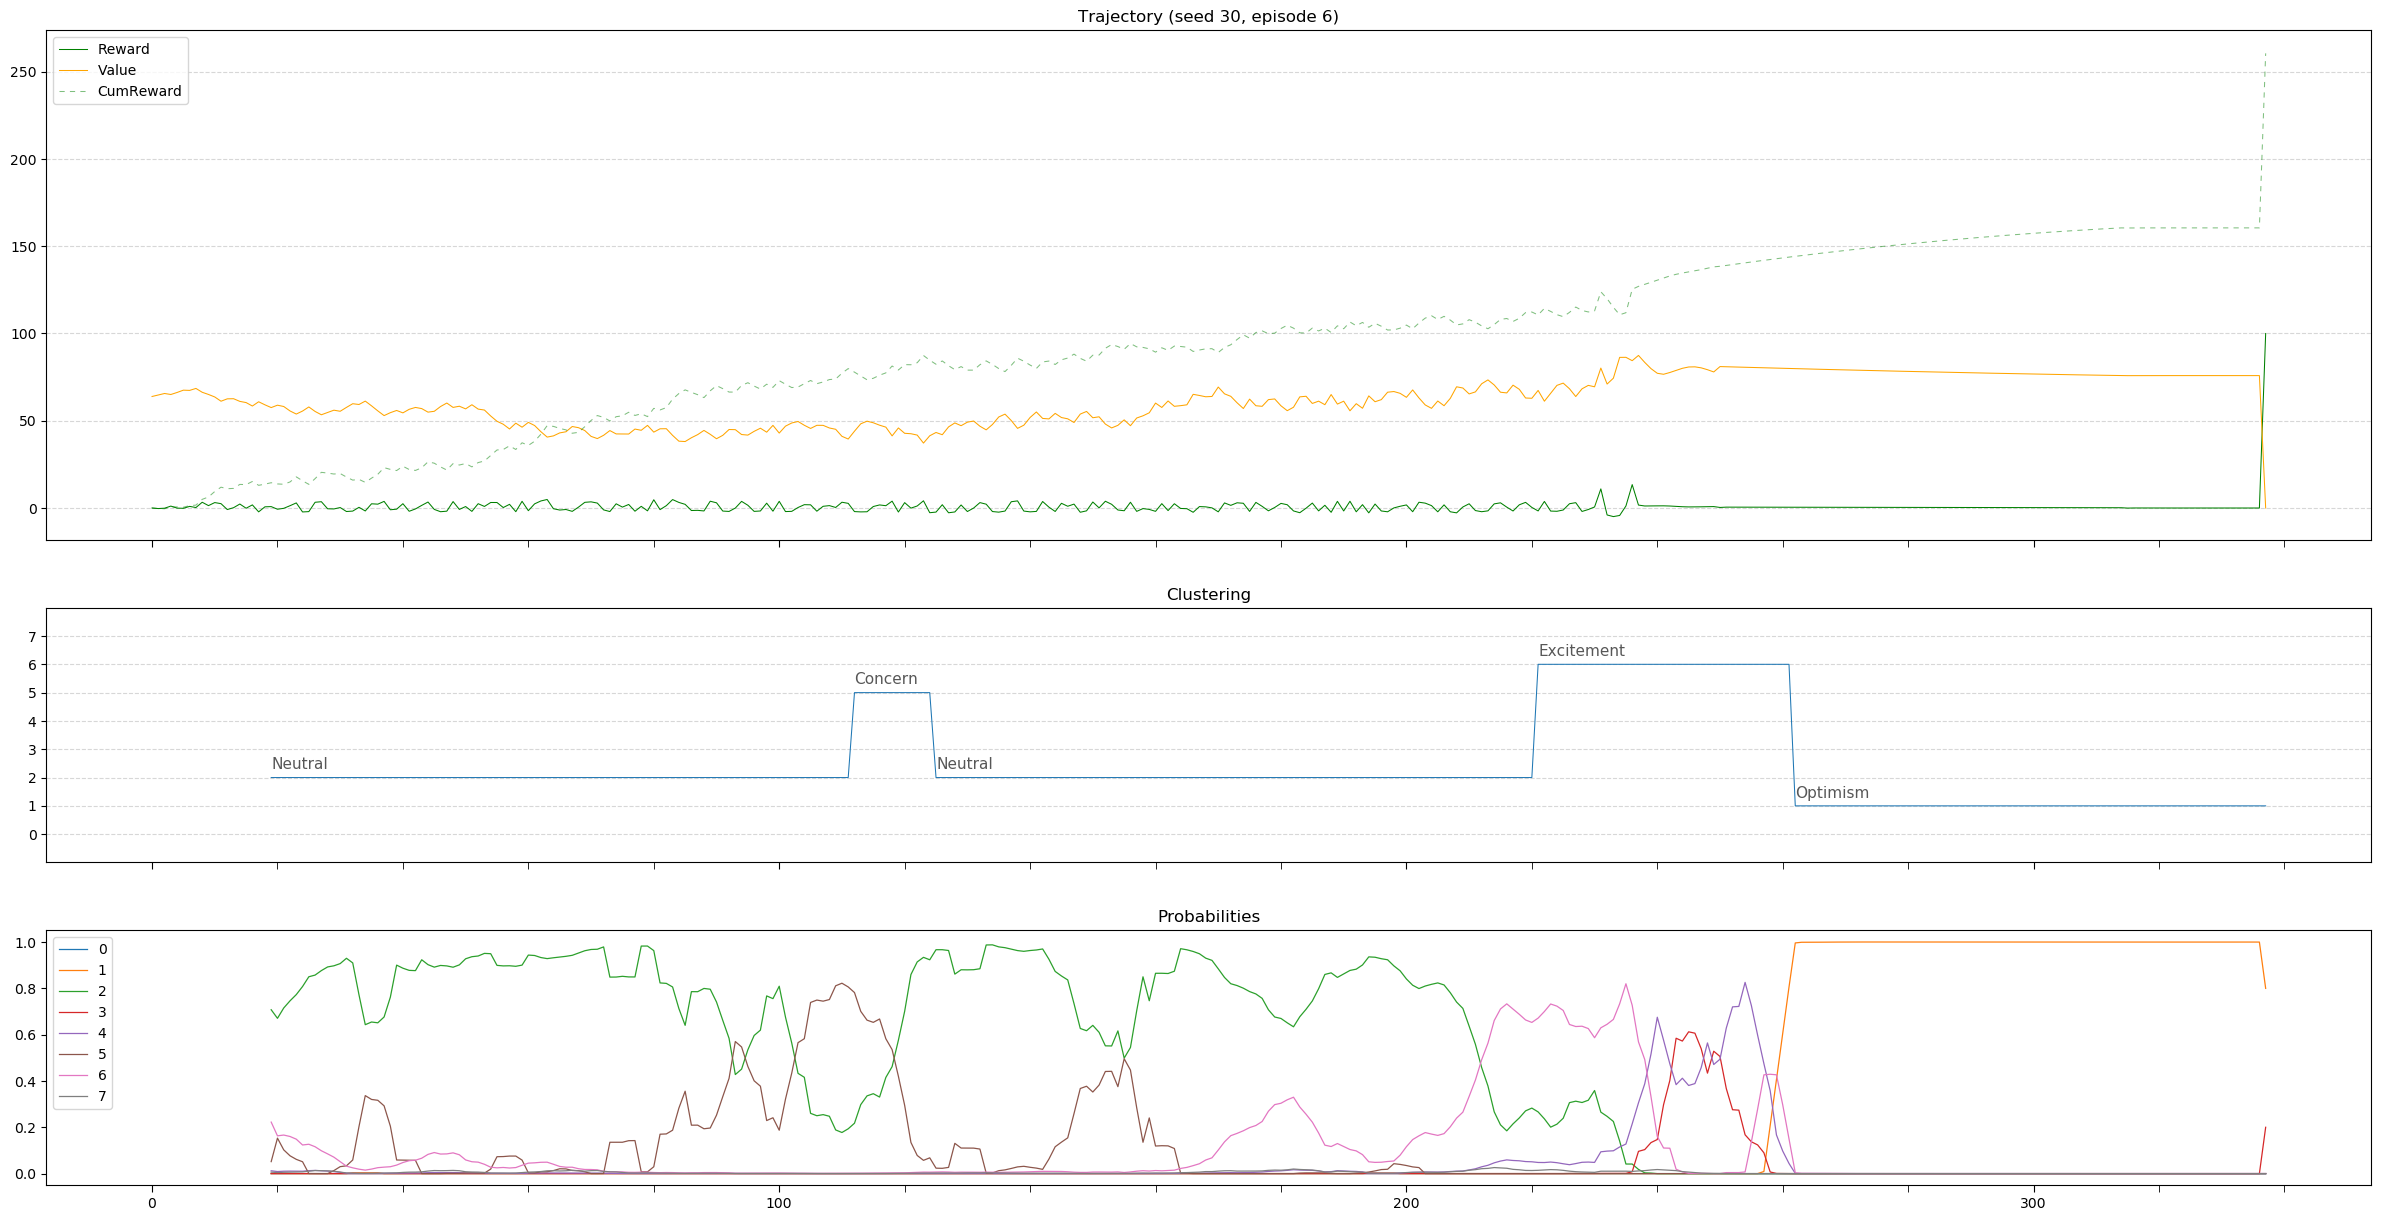

In [43]:
cl.draw_real_time_clustering_of_one_trajectory(
    traj_list, seed, episode, df_probs_smooth, n_components, ae_columns,
    cum_columns=['Reward'], cluster_names=emotional_attribution, log_scale=False,
)

#### Anaylisis of emotional sequences

Calculate a transition matrix representing transtions betweeen emotions
- Rows: "From emotion"
- Columns: "To emotion" 

In [68]:
emotion_transition_matrix = cl.create_transition_matrix(df_probs, n_components)
emotion_transition_matrix

array([[   0,    0,    0,   31,    0,    6,    2,   21,    0,    0],
       [   0, 1646,    0,   90,    0,    0,   22,    0,    7,    0],
       [   0,    0,  817,    1,   38,    8,    0,   34,    0,    0],
       [   0,   77,    4, 5305,    3,    0,  372,  212,   50,    0],
       [   0,    0,    0,    0,  575,   79,    0,    1,   20,   58],
       [   0,    0,   13,    0,   82, 2930,    0,  310,    6,    0],
       [   0,   33,    0,  343,   14,    0, 2140,    0,    5,    1],
       [   0,    0,   64,  186,    6,  308,    0, 3342,   43,    1],
       [   0,    9,    0,   67,   15,   10,    0,   30,  843,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

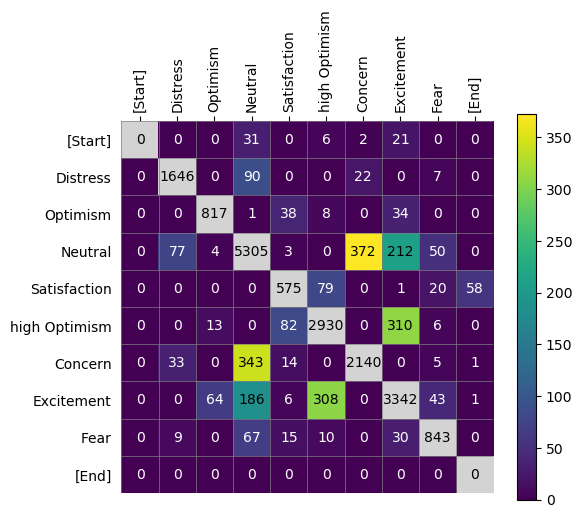

In [120]:
cl.draw_emotion_transition_matrix(emotion_transition_matrix, emotional_attribution)

#### Save generated models and info

Save the clustering model

In [123]:
clustering_model_name = 'gaussian_mixture_02'

filename = os.path.join(output_path, clustering_model_name) + '.sav'
pickle.dump(gm_model, open(filename, 'wb'))
print(f"Clustering model saved to: {filename}")

Clustering model saved to: /Users/Alberto/Code/love-emotional-framework/data/new_runs/gaussian_mixture_02.sav


In [124]:
# Test saved model.
loaded_model = pickle.load(open(filename, 'rb'))

new_labels = loaded_model.predict(all_encodings)
print(np.all(gm_labels == new_labels))
new_probs = loaded_model.predict_proba(all_encodings)
print(np.all(gm_labels_prob == new_probs))

True
True


Save clustering info for all trajectories

In [125]:
clustering_info_file = os.path.join(output_path, clustering_model_name) + '_clustering.txt'

df_probs_smooth.to_csv(  # Save the smoothened version.
    clustering_info_file,
    sep='\t', header=df_probs_smooth.columns,
)
print(f"Step-wise clustering info saved to: {clustering_info_file}")

Step-wise clustering info saved to: /Users/Alberto/Code/love-emotional-framework/data/new_runs/gaussian_mixture_02_clustering.txt


Save emotion attribution dictionary.

In [126]:
dict_filename = os.path.join(output_path, clustering_model_name) + '_clustering.dic'

pickle.dump(emotional_attribution, open(dict_filename, 'wb'))
print(f"Emotional attribution names saved to: {dict_filename}")

Emotional attribution names saved to: /Users/Alberto/Code/love-emotional-framework/data/new_runs/gaussian_mixture_02_clustering.dic


In [127]:
# Test saved dict.
loaded_dict = pickle.load(open(dict_filename, 'rb'))
emotional_attribution == loaded_dict

True